<a href="https://colab.research.google.com/github/Fritz302/data-science/blob/main/FritKokiUnit8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install pymc-bart
import pymc_bart as pmb

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Fritz302/data-science/refs/heads/main/Fortnite_players_stats%20-%20Fortnite_players_stats%20(1).csv')
data

,Player,Solo score,Solo top1,Solo kd,Solo winRatio,Solo matches,Solo kills,Solo minutesPlayed
0,Prospеring,2476763,1828,4.37,18.0,10150,36328,81389
1,BH nixxxay,439562,1694,8.71,29.1,5817,35895,12732
2,Raпger,4519465,4582,9.60,34.0,13488,85481,122171
3,Idk_Pi,752869,121,0.84,3.3,3687,3005,32453
4,Twitch.GryphonRB,1136282,1327,6.32,30.0,4429,19591,36245
...,...,...,...,...,...,...,...,...
1430,im bloom,106294,26,2.03,3.5,736,1440,4470
1431,Twitch kaOzs_,803918,396,3.42,13.2,3001,8911,27375
1432,slxyher,603939,310,1.69,5.1,6035,9679,20545
1433,RD-Antony,747295,71,1.10,1.9,3763,4048,31147


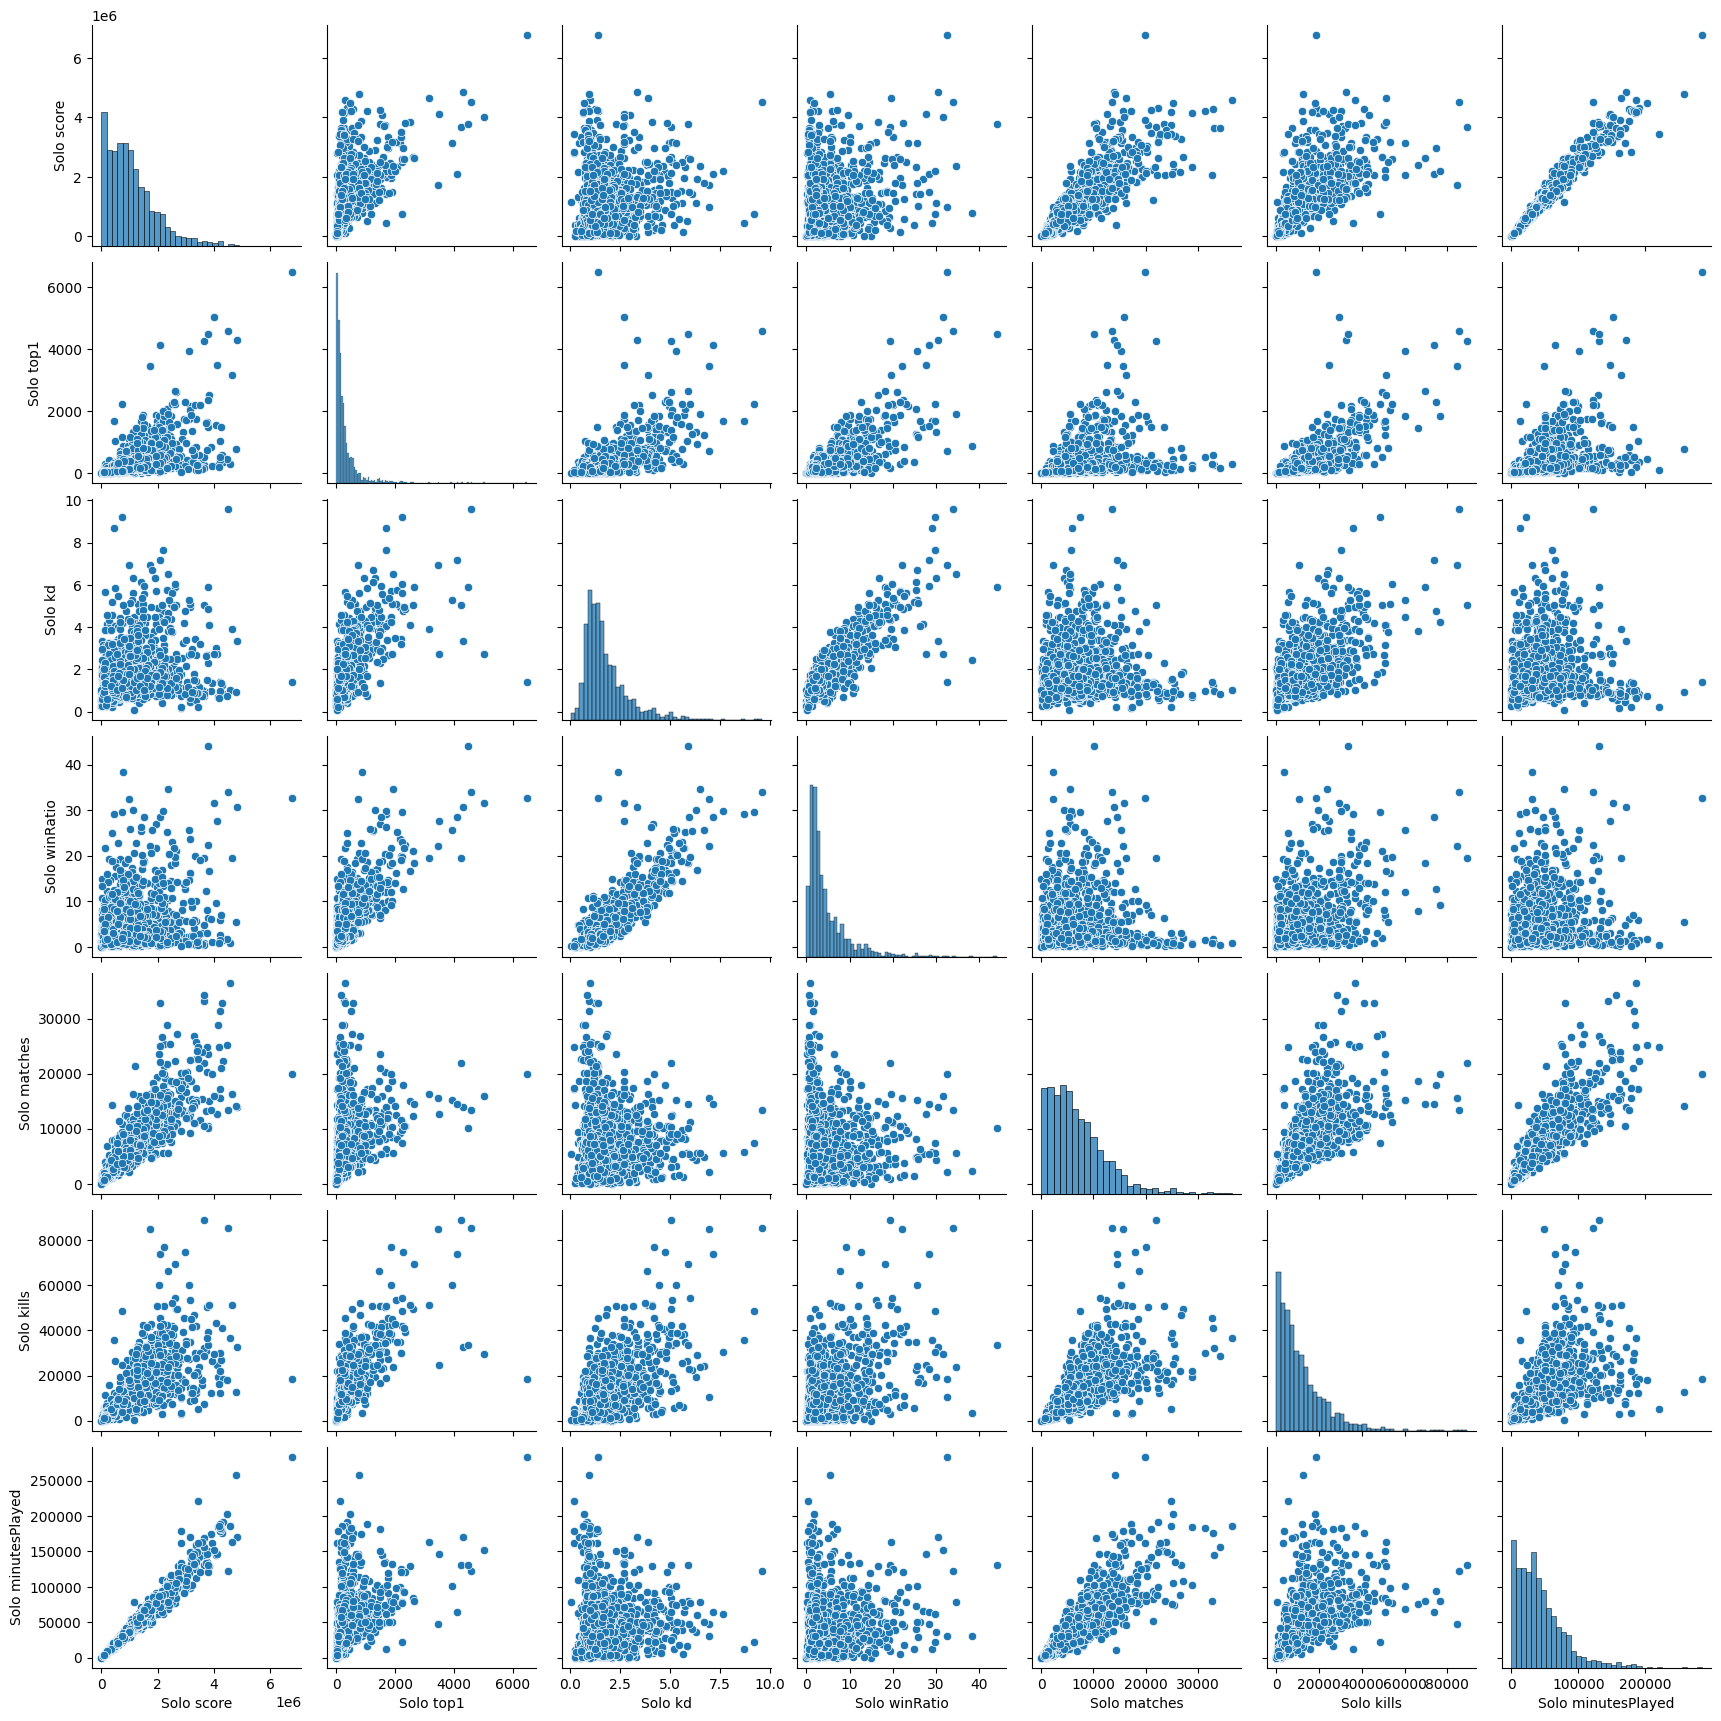

In [4]:
sns.pairplot(data)

I went through 5 data sets before I finally found one with enough data and actual correlations.

**Intro**

Fortnite is a Battle Royale game, meaning you have to be the last player surviving to win. This means that it doesn't matter how good you do in other categories, as long as you get the win. In this project, I want to predicate the number of Fortnite Solo wins a player will have (basically how good they are at the game) based upon their score, KD, and win ratio.

Fortnite Solo Score is a number that is supposed to show how good a player is. You get points from doing damage, farming materials, getting eliminations, and other important game statistics.

KD is a player's Kill-Death Ratio, meaning how many kills do they get per death, and since this is all solos, it basically means kills per match.

Win ratio is in the name, as it is the amount of wins a player has divided by the number of games they've played.


In [4]:
stats = ["Solo score", "Solo kd","Solo winRatio"]

X = data[stats]
Y = data["Solo top1"].to_numpy()

In [6]:
with pm.Model() as model_fortnite:
    s = pm.HalfNormal('s',1000)
    μ = pmb.BART("μ_", X, Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_fortnite = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

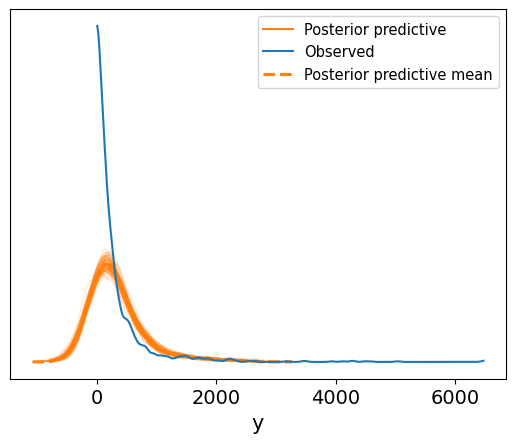

In [7]:
pm.sample_posterior_predictive(idata_fortnite,model_fortnite, extend_inferencedata=True)
az.plot_ppc(idata_fortnite, num_pp_samples=100, colors=["C1", "C0", "C1"])

**First Model (Normal)**

This model did horribly because it tried to predict negative values with a normal curve when my data curved more like it was exponential. My data has no negative values so I will try a Gamma model next.

In [15]:
with pm.Model() as model_FortGamma:
    s = pm.HalfNormal('s',1000)
    μ = pmb.BART("μ", X, Y, m=50)
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_FortGamma = pm.sample(compute_convergence_checks=False)

Output()

SamplingError: Bad initial energy: SamplerWarning(kind=<WarningType.BAD_ENERGY: 8>, message='Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:\n[-inf]\n.Try model.debug() to identify parametrization problems.', level='critical', step=0, exec_info=None, extra=None, divergence_point_source=None, divergence_point_dest=None, divergence_info=None)

**1st Gamma Model**

My first gamma model didn't run, which ended up being because my Y (solo wins) had too many 0's in the data. To fix this, I added 1 to every data point.

In [18]:
Y = Y + 1

In [22]:
with pm.Model() as model_FortGam:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_FortGam = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

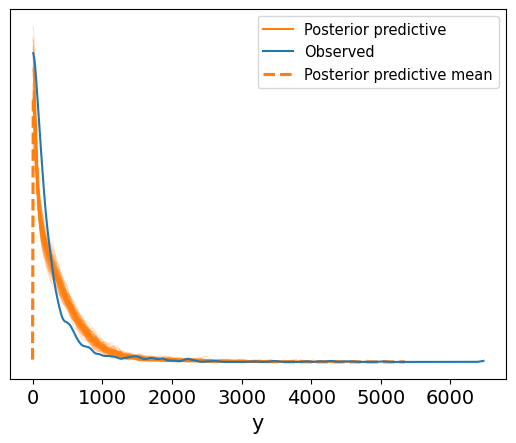

In [23]:
pm.sample_posterior_predictive(idata_FortGam,model_FortGam, extend_inferencedata=True)
az.plot_ppc(idata_FortGam, num_pp_samples=100, colors=["C1", "C0", "C1"])

**2nd Gamma Model**

After adding one to each Y value, the curve was pretty well fit. I don't think I can do much better for now so I'm going to go ahead on the Posterior Predictive Check.

In [24]:
posterior_mean = idata_FortGam.posterior["μ"]

μ_hdi = az.hdi(ary=idata_FortGam, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_FortGam, group="posterior_predictive", var_names=["y"]
).T

In [25]:
Xn = X.to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


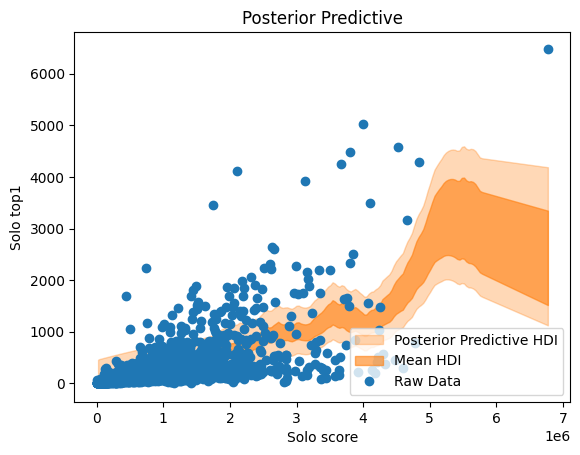

In [26]:
idx = np.argsort(Xn[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(data["Solo score"], data["Solo top1"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Solo score",
    ylabel="Solo top1",
);

**Conclusion**

My model didn't work that great. It failed to capture a lot of the data points  but it does show a somewhat general trend, with the data getting much more variable with high solo score. If I had more time, I think I would switch up my variables. I think the fact that my data had a lot of 0's might've indicated that I should've predicted a different value or used a different set altogether.